In [13]:
!pip install scikeras

In [14]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from PIL import Image
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

import keras
import scikeras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report

from keras.applications.resnet50 import ResNet50

In [16]:
folder_benign_train = '/content/drive/MyDrive/CNN skin cancer/train/benign'
folder_malignant_train = '/content/drive/MyDrive/CNN skin cancer/train/malignant'

folder_benign_test = '/content/drive/MyDrive/CNN skin cancer/test/benign'
folder_malignant_test = '/content/drive/MyDrive/CNN skin cancer/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Ładowanie plików treningowych
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Ładowanie plików testowych
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Tworzenie oznaczeń
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Łączenie danych z oznaczeniami
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Losowanie danych
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]


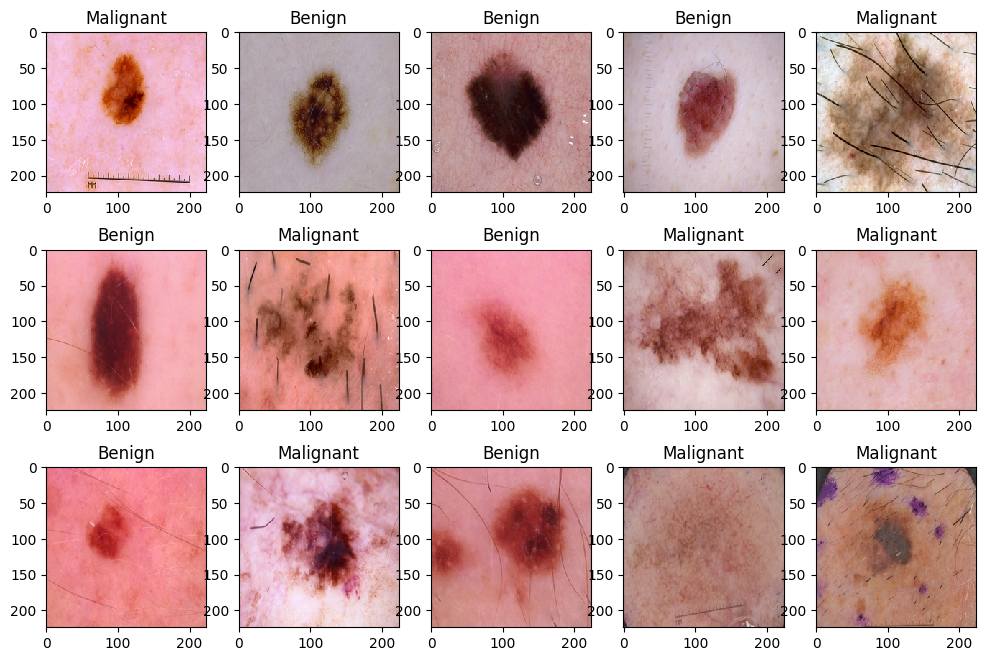

In [17]:
# Wyświetl pierwsze 15 zdjęć oraz ich oznaczenia
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [18]:
# Kodowanie One-Hot dla oznaczeń
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [19]:
# Argumentacja danych aby zapobiec nadmiernu dopasowaniu
X_train = X_train/255.
X_test = X_test/255.

Epoch 1/50
33/33 - 74s - loss: 0.5379 - accuracy: 0.7492 - val_loss: 0.6954 - val_accuracy: 0.5568 - lr: 1.0000e-04 - 74s/epoch - 2s/step
Epoch 2/50
33/33 - 24s - loss: 0.4473 - accuracy: 0.7876 - val_loss: 0.6997 - val_accuracy: 0.5568 - lr: 1.0000e-04 - 24s/epoch - 719ms/step
Epoch 3/50
33/33 - 24s - loss: 0.3809 - accuracy: 0.8184 - val_loss: 0.7504 - val_accuracy: 0.5568 - lr: 1.0000e-04 - 24s/epoch - 728ms/step
Epoch 4/50
33/33 - 23s - loss: 0.3641 - accuracy: 0.8307 - val_loss: 0.7051 - val_accuracy: 0.5568 - lr: 1.0000e-04 - 23s/epoch - 709ms/step
Epoch 5/50
33/33 - 23s - loss: 0.3557 - accuracy: 0.8355 - val_loss: 0.8174 - val_accuracy: 0.5568 - lr: 1.0000e-04 - 23s/epoch - 710ms/step
Epoch 6/50
33/33 - 23s - loss: 0.3479 - accuracy: 0.8421 - val_loss: 0.6503 - val_accuracy: 0.6136 - lr: 1.0000e-04 - 23s/epoch - 693ms/step
Epoch 7/50
33/33 - 23s - loss: 0.3288 - accuracy: 0.8440 - val_loss: 0.8519 - val_accuracy: 0.5568 - lr: 1.0000e-04 - 23s/epoch - 711ms/step
Epoch 8/50
33/33

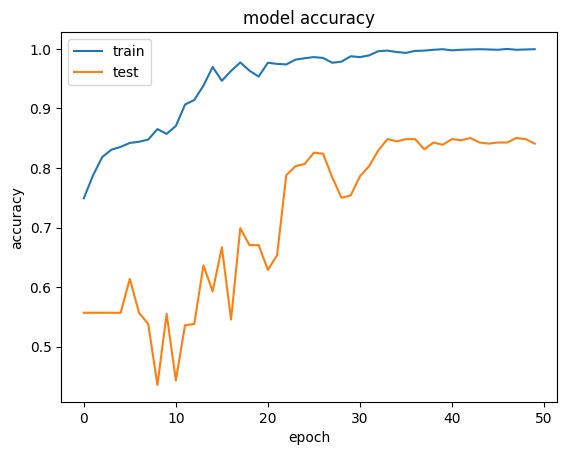

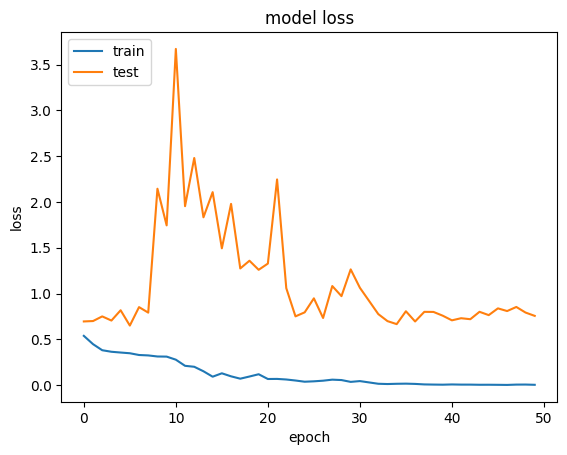

In [20]:
input_shape = (224,224,3)
lr = 0.0001
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

# Ustaw "odprężacz" współczynniku uczenia
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000005)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2,
                    callbacks=[learning_rate_reduction]
                   )

# Wypisz całą date w wartości "history"
print(history.history.keys())
# Streść historie na dokładność
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Streść historie na utrate
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# Przetestuj model na danych testowych
predict_prob=model.predict([X_test])
predict_classes=np.argmax(predict_prob,axis=1)
print(predict_classes)
# Klasyfikacja danych testowych
y_test_label = np.argmax(y_test, axis=1)
# Wypisz kształt
print(y_test_label.shape, predict_classes.shape)
# Tworzenie raportu klasyfikacji dla danych testowych
print(classification_report(y_test_label, predict_classes))

21/21 [==============================] - 5s 133ms/step
[0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0
 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1
 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1
 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 1
 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1
 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0
 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0
 1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0
 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1
 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 

In [22]:
model_name = 'CNN'
subject = 'Skin Cancer'
save_path = ''

# Zapisz model
save_id = str({model_name})
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'Model zapisany jako: {model_save_loc}')

# Zapisz wagi modelu
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'Wagi modelu zapisano jako {weights_save_loc}')

Model zapisany jako: {'CNN'}
Wagi modelu zapisano jako CNN-Skin Cancer-weights.h5
